## ERDAP with erddapy example for FCOM ITAE Prawler

__pyversion__==3.7   
__author__==S.Bell

__Notes:__ 
+ Raw Science Units are what is being hosted on ERDDAP client.    
+ Salinity must be calculated from Conductivity   
+ OxyConc must be corrected for Salinity/Press   
+ Turb/Chlor must be calculated from counts   
+ TELOS ('http://heron:8080/erddap') erddap doesn't keep a divenumber value (and its not trivial to sort this data) so second erddap is hosting this data in order to keep that parameter ('http://downdraft.pmel.noaa.gov:8080/erddap') some preprocessing is happening there prior to data posting.  Incomming -> Science -> QC'd data is a source of future conversation for erddap hosting.

__Todo:__
+ Initial QC can be done   
+ csv files of converted data should be archived at end of deployment?

***
There is an issue with the SBE temp probe... 
***

In [ ]:
import datetime
print("Last run {0}".format(datetime.datetime.now()))

Last run 2021-08-12 16:43:18.127503


### connecting and basic information

In [ ]:
from erddapy import ERDDAP
import pandas as pd
import numpy as np

import seawater as sw
import calc.aanderaa_corrO2_sal as optode_O2_corr

server_url = 'http://akutan.pmel.noaa.gov:8080/erddap'
server_url = 'http://redwing:8081/erddap'
#alternate server_url = 'http://redwing:8080/erddap'

e = ERDDAP(server=server_url)

In [ ]:
df = pd.read_csv(e.get_search_url(response='csv', search_for='TELOMCL0_PRAWC_MCL0'))

In [ ]:
'We have {} tabledap, {} griddap, and {} wms endpoints.'.format(
    len(set(df['tabledap'].dropna())),
    len(set(df['griddap'].dropna())),
    len(set(df['wms'].dropna()))
)

'We have 6 tabledap, 0 griddap, and 0 wms endpoints.'

In [ ]:
prawlers = df['Dataset ID'].values
print(prawlers)

['TELORC12_ATRH_RC12' 'TELORC12_BARO_RC12' 'TELORC12_GPS_RC12'
 'TELORC12_LOAD_RC12' 'TELORC12_PRAWE_RC12' 'TELORC12_WIND_RC12']


In [ ]:
variables = [e.get_var_by_attr(dataset_id=prawler, standard_name=lambda v: v is not None) for prawler in prawlers]
print(variables)

[['RH_Std', 'time', 'RH'], ['time'], ['Latitude', 'time', 'Longitude'], ['Ave_Load', 'Load_Temp', 'Max_Load', 'time', 'Std_Load', 'Min_Load'], ['Depth', 'time', 'SRate', 'ETimer', 'IRate'], ['time']]


### retrieving and plotting data

In [7]:
d = ERDDAP(server=server_url,
           protocol='tabledap',
           response='csv',
          )

d.dataset_id='TELOMCL0_PRAWC_MCL0'

d.variables =  [
 'SB_Depth',
 'SB_Temp',
 'SB_Conductivity',
 'Optode_Temp',
 'Optode_Dissolved_O2',
 'wetlab_Chlorophyll',
 'wetlab_FDOM',
 "time"
]


d.constraints = {
    'time>=': '2021-06-01T00:00:00Z',
    'time<=': '2021-08-01T00:00:00Z',
}

In [8]:
d.get_download_url()

'http://redwing:8081/erddap/tabledap/TELOMCL0_PRAWC_MCL0.csv?SB_Depth,SB_Temp,SB_Conductivity,Optode_Temp,Optode_Dissolved_O2,wetlab_Chlorophyll,wetlab_FDOM,time&time>=1622505600.0&time<=1627776000.0'

In [9]:
df = d.to_pandas(
    index_col='time (UTC)',
    parse_dates=True,
    skiprows=(1,)  # units information can be dropped.
).dropna()

df.sort_index(inplace=True)
df.columns = [x[1].split()[0] for x in enumerate(df.columns)]

df = df.sort_index()

df.head()

HTTPError: <!doctype html><html lang="en"><head><title>HTTP Status 404 – Not Found</title><style type="text/css">h1 {font-family:Tahoma,Arial,sans-serif;color:white;background-color:#525D76;font-size:22px;} h2 {font-family:Tahoma,Arial,sans-serif;color:white;background-color:#525D76;font-size:16px;} h3 {font-family:Tahoma,Arial,sans-serif;color:white;background-color:#525D76;font-size:14px;} body {font-family:Tahoma,Arial,sans-serif;color:black;background-color:white;} b {font-family:Tahoma,Arial,sans-serif;color:white;background-color:#525D76;} p {font-family:Tahoma,Arial,sans-serif;background:white;color:black;font-size:12px;} a {color:black;} a.name {color:black;} .line {height:1px;background-color:#525D76;border:none;}</style></head><body><h1>HTTP Status 404 – Not Found</h1><hr class="line" /><p><b>Type</b> Status Report</p><p><b>Message</b> Resource not found: &#47;erddap&#47;tabledap&#47;TELOMCL0_PRAWC_MCL0.csvp (Currently unknown datasetID=TELOMCL0_PRAWC_MCL0)</p><p><b>Description</b> The origin server did not find a current representation for the target resource or is not willing to disclose that one exists.</p><hr class="line" /><h3>Apache Tomcat/8.5.34</h3></body></html>

In [10]:
df.tail()

NameError: name 'df' is not defined

In [12]:
# #temp load from local
ctd_pd = 'FCOM9998_202107.1.csv'
df = pd.read_csv(ctd_pd,index_col='datetime',skiprows=[1],parse_dates=True)
df.index.name = 'time (UTC)'

df.rename(columns={'CC':'SB_Conductivity','CT':'SB_Temp','CD':'SB_Depth','OT':'Optode_Temp'},inplace=True)
df.sample()

,profilenumber,ep,SB_Depth,SB_Temp,SB_Conductivity,Optode_Temp,02,CH,TB,S,O2_corr,O2_corr_umkg,O2PercentSat,dep_lat,dep_lon
time (UTC),,,,,,,,,,,,,,,
2021-07-04 04:46:37,153,60E13D2D,29.67,11.567,3.414,11.531,271.39,-1.356,-10.3122,29.678662,225.136171,220.145139,79.806944,71.2167,-164.25


In [13]:
df = df.loc[datetime.date(2021,7,2).strftime('%Y-%m-%d'):]

/var/folders/vv/blq095kj0xj9nz1v0ffdwfch0000gp/T/ipykernel_48119/364490012.py:1: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df = df.loc[datetime.date(2021,7,2).strftime('%Y-%m-%d'):]


#### Temperature

In [14]:
#qc
df['SB_Temp'][df['SB_Temp']>20]=np.nan

/var/folders/vv/blq095kj0xj9nz1v0ffdwfch0000gp/T/ipykernel_48119/790347720.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['SB_Temp'][df['SB_Temp']>20]=np.nan


In [15]:
import matplotlib as mpl
import matplotlib.pyplot as plt

### specify primary bulk figure parameters
fontsize = 10
labelsize = 10
#plotstyle = 'seaborn'
max_xticks = 10
plt.style.use('seaborn-ticks')
mpl.rcParams['svg.fonttype'] = 'none'
mpl.rcParams['ps.fonttype'] = 42 #truetype/type2 fonts instead of type3
mpl.rcParams['pdf.fonttype'] = 42 #truetype/type2 fonts instead of type3
mpl.rcParams['axes.grid'] = False
mpl.rcParams['axes.edgecolor'] = 'black'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.labelcolor'] = 'black'
mpl.rcParams['grid.linestyle'] = '--'
mpl.rcParams['grid.linestyle'] = '--'
mpl.rcParams['xtick.major.size'] = 4
mpl.rcParams['xtick.minor.size'] = 2
mpl.rcParams['xtick.major.width'] = 2
mpl.rcParams['xtick.minor.width'] = 0.5
mpl.rcParams['ytick.major.size'] = 4
mpl.rcParams['ytick.minor.size'] = 2
mpl.rcParams['ytick.major.width'] = 2
mpl.rcParams['ytick.minor.width'] = 0.5
mpl.rcParams['ytick.direction'] = 'out'
mpl.rcParams['xtick.direction'] = 'out'
mpl.rcParams['ytick.color'] = 'black'
mpl.rcParams['xtick.color'] = 'black'

In [16]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import YearLocator, WeekdayLocator, MonthLocator, DayLocator, HourLocator, DateFormatter
import matplotlib.ticker as ticker

import cmocean

Text(0, 0.5, 'Depth (m)')

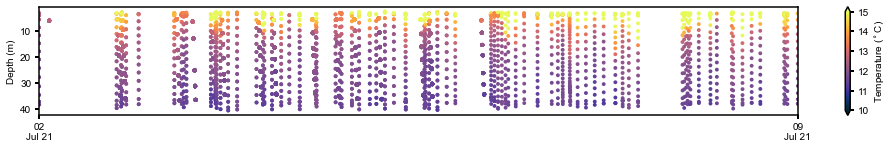

In [17]:
fig, ax = plt.subplots(figsize=(17, 2))
cs = ax.scatter(df.index, df['SB_Depth'], s=15, c=df['SB_Temp'], 
                marker='o', edgecolor='none', cmap=cmocean.cm.thermal,
               vmin=10, vmax=15) #<---
ax.invert_yaxis()
ax.set_xlim(df.index[0], df.index[-1])
xfmt = mdates.DateFormatter('%d-%b')
ax.xaxis.set_major_locator(DayLocator(bymonthday=15))
ax.xaxis.set_minor_locator(DayLocator(range(0,32,15)))
ax.xaxis.set_minor_formatter(DateFormatter('%d'))
ax.xaxis.set_major_formatter(DateFormatter('%d\n%b %y'))
ax.xaxis.set_tick_params(which='major', pad=3)
ax.xaxis.set_tick_params(which='minor', pad=5)

cbar = fig.colorbar(cs, orientation='vertical', extend='both')
cbar.ax.set_ylabel('Temperature ($^\circ$C)')
ax.set_ylabel('Depth (m)')


Text(0, 0.5, 'Depth (m)')

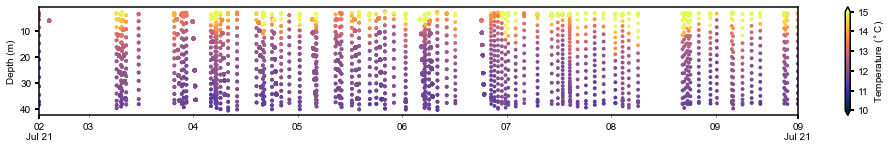

In [18]:
fig, ax = plt.subplots(figsize=(17, 2))
cs = ax.scatter(df.index, df['SB_Depth'], s=15, c=df['Optode_Temp'], 
                marker='o', edgecolor='none', cmap=cmocean.cm.thermal,
               vmin=10, vmax=15) #<---
ax.invert_yaxis()
ax.set_xlim(df.index[0], df.index[-1])
xfmt = mdates.DateFormatter('%d-%b')
ax.xaxis.set_major_locator(DayLocator(bymonthday=15))
ax.xaxis.set_minor_locator(DayLocator(range(0,32,1)))
ax.xaxis.set_minor_formatter(DateFormatter('%d'))
ax.xaxis.set_major_formatter(DateFormatter('%d\n%b %y'))
ax.xaxis.set_tick_params(which='major', pad=3)
ax.xaxis.set_tick_params(which='minor', pad=5)

cbar = fig.colorbar(cs, orientation='vertical', extend='both')
cbar.ax.set_ylabel('Temperature ($^\circ$C)')
ax.set_ylabel('Depth (m)')


In [19]:
print("""
max temp: {0:0.4}
min temp: {1:0.4}""".format(df['SB_Temp'].max(), df['SB_Temp'].min()))


max temp: 17.48
min temp: 11.15


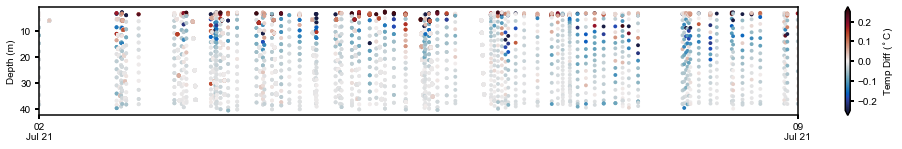

In [20]:
#plot
fig, ax = plt.subplots(figsize=(17, 2))
cs = ax.scatter(df.index, df['SB_Depth'], s=15, c=df['SB_Temp']-df['Optode_Temp'], 
                marker='o', edgecolor='none', vmin=-.25,vmax=.25,cmap=cmocean.cm.balance)

ax.invert_yaxis()
ax.set_xlim(df.index[0], df.index[-1])
xfmt = mdates.DateFormatter('%d-%b')
ax.xaxis.set_major_locator(DayLocator(bymonthday=15))
ax.xaxis.set_minor_locator(DayLocator(range(0,32,15)))
ax.xaxis.set_minor_formatter(DateFormatter('%d'))
ax.xaxis.set_major_formatter(DateFormatter('%d\n%b %y'))
ax.xaxis.set_tick_params(which='major', pad=3)
ax.xaxis.set_tick_params(which='minor', pad=5)

cbar = fig.colorbar(cs, orientation='vertical', extend='both')
cbar.ax.set_ylabel('Temp Diff ($^\circ$C)')
ax.set_ylabel('Depth (m)');

Text(0, 0.5, 'Depth (m)')

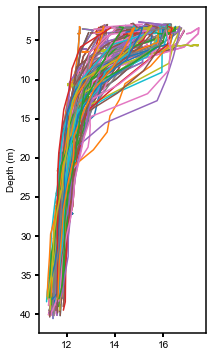

In [21]:
dfg = df.groupby('profilenumber')
fig, ax = plt.subplots(figsize=(3, 6))
for group in dfg.groups.keys():
    dfsg = dfg.get_group(group)
    cs = ax.plot(dfsg['SB_Temp'], dfsg['SB_Depth'])

#ax.set_xlim([-.35,.25])
ax.invert_yaxis()
cbar.ax.set_ylabel('Temperature ($^\circ$C)')
ax.set_ylabel('Depth (m)')


Text(0, 0.5, 'Depth (m)')

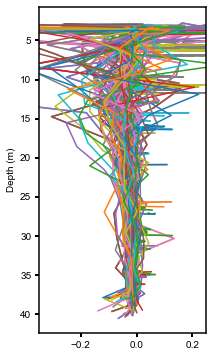

In [22]:
dfg = df.groupby('profilenumber')
fig, ax = plt.subplots(figsize=(3, 6))
for group in dfg.groups.keys():
    dfsg = dfg.get_group(group)
    cs = ax.plot(dfsg['SB_Temp']-dfsg['Optode_Temp'], dfsg['SB_Depth'])

ax.set_xlim([-.35,.25])
ax.invert_yaxis()
cbar.ax.set_ylabel('Temperature ($^\circ$C)')
ax.set_ylabel('Depth (m)')


Text(0, 0.5, 'Depth (m)')

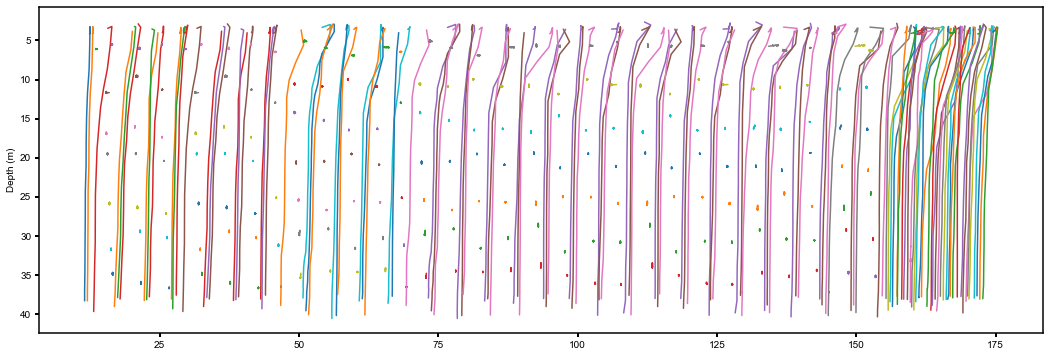

In [23]:
dfg = df.groupby('profilenumber')
fig, ax = plt.subplots(figsize=(18, 6))
count=0
for group in dfg.groups.keys():
    dfsg = dfg.get_group(group)
    cs = ax.plot(dfsg['SB_Temp']+.5*count, dfsg['SB_Depth'])
    count+=1

ax.invert_yaxis()
cbar.ax.set_ylabel('Temperature ($^\circ$C)')
ax.set_ylabel('Depth (m)')


In [24]:
## Distribution of temperature differences

import seaborn as sns

/Users/bell/miniconda3/envs/py38/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


(-0.25, 0.25)

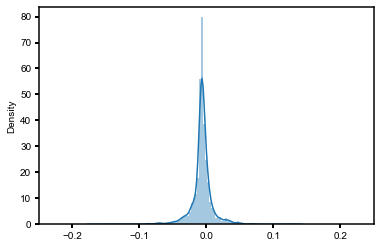

In [25]:
ax = sns.distplot(df[df.SB_Depth>20]['SB_Temp']-df[df.SB_Depth>20]['Optode_Temp'],bins=100)
ax.set_xlim(-.25,.25)

/Users/bell/miniconda3/envs/py38/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


(-0.25, 0.25)

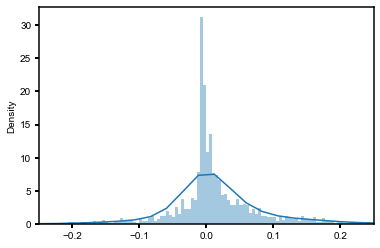

In [26]:
ax = sns.distplot(df[df.SB_Depth<20]['SB_Temp']-df[df.SB_Depth<20]['Optode_Temp'],bins=1000)
ax.set_xlim(-.25,.25)


In [27]:
dfsub = df.loc[datetime.datetime(2021,7,6,18).strftime('%Y-%m-%d %H')]

/var/folders/vv/blq095kj0xj9nz1v0ffdwfch0000gp/T/ipykernel_48119/3952726377.py:4: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  if profile.std()['SB_Depth'] < 1:


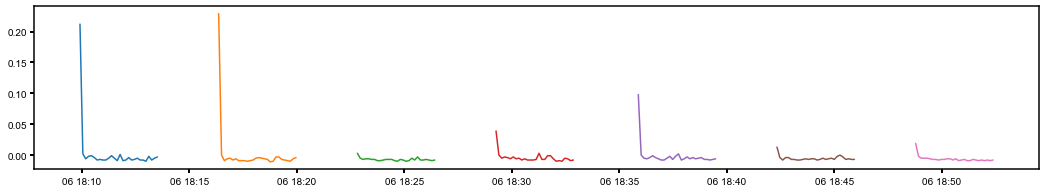

In [28]:
fig, ax = plt.subplots(figsize=(18, 3))

for i,profile in dfsub.groupby('profilenumber'):
    if profile.std()['SB_Depth'] < 1:
        ax.plot(profile['SB_Temp']-profile['Optode_Temp'])


/var/folders/vv/blq095kj0xj9nz1v0ffdwfch0000gp/T/ipykernel_48119/3941697226.py:4: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  if profile.std()['SB_Depth'] < 1:
/var/folders/vv/blq095kj0xj9nz1v0ffdwfch0000gp/T/ipykernel_48119/3941697226.py:11: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  if profile.std()['SB_Depth'] < 1:


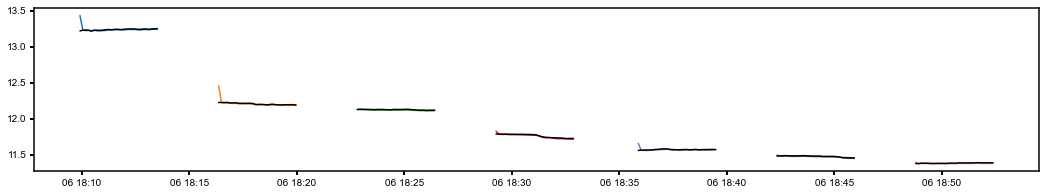

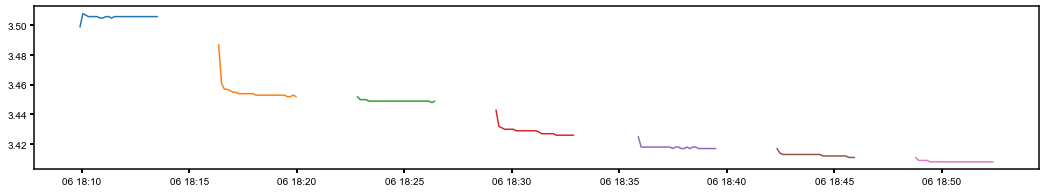

In [33]:
fig, ax = plt.subplots(figsize=(18, 3))

for i,profile in dfsub.groupby('profilenumber'):
    if profile.std()['SB_Depth'] < 1:
        ax.plot(profile['SB_Temp'])
        ax.plot(profile['Optode_Temp'],'k')

fig, ax = plt.subplots(figsize=(18, 3))

for i,profile in dfsub.groupby('profilenumber'):
    if profile.std()['SB_Depth'] < 1:
        ax.plot(profile['SB_Conductivity'])


In [40]:
dfsub[['ep','SB_Depth','SB_Temp','SB_Conductivity','Optode_Temp']]['2021-07-06'].to_csv('final_park_and_hold.csv')

/var/folders/vv/blq095kj0xj9nz1v0ffdwfch0000gp/T/ipykernel_48119/770952929.py:1: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  dfsub[['ep','SB_Depth','SB_Temp','SB_Conductivity','Optode_Temp']]['2021-07-06'].to_csv('final_park_and_hold.csv')


In [27]:
for i,profile in dfsub.groupby('profilenumber'):
    if profile.std()['SB_Depth'] < 1:
        print(profile.mean()['SB_Depth'])


5.628571428571428
11.21107142857143
16.13214285714286
21.083928571428572
26.47428571428571
29.243928571428565
34.683928571428574
6.269285714285714
10.989999999999998
16.381785714285716
21.62035714285715
24.53107142857143
30.388928571428576
35.18
5.949642857142857
10.731785714285717
15.409642857142858
19.37964285714286
26.199285714285715
30.552500000000006
34.387857142857136
5.628571428571428
11.21107142857143
16.13214285714286
21.083928571428572
26.47428571428571
29.243928571428565
34.683928571428574
6.269285714285714
10.989999999999998
16.381785714285716
21.62035714285715
24.53107142857143
30.388928571428576
35.18


Text(0, 0.5, 'Depth (m)')

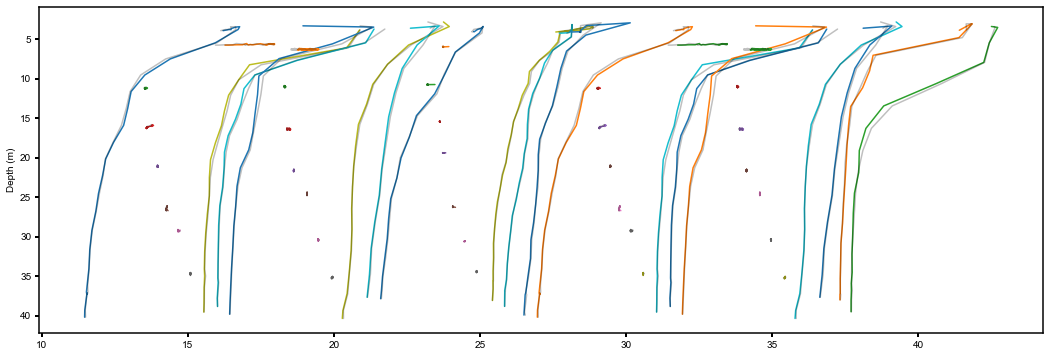

In [28]:
fig, ax = plt.subplots(figsize=(18, 6))
count=0
for i,profile in dfsub.groupby('profilenumber'):
    cs = ax.plot(profile['SB_Temp']+.5*count, profile['SB_Depth'])
    cs = ax.plot(profile['Optode_Temp']+.5*count, profile['SB_Depth'],'k',alpha=.25)
    count+=1

ax.invert_yaxis()
cbar.ax.set_ylabel('Temperature ($^\circ$C)')
ax.set_ylabel('Depth (m)')
